# Neural Network - Tensor Flow

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Import the dataset
df = pd.read_csv('outputs/train_cleaned.csv')

# Review the shape of the dataset
print(df.shape)

(1460, 84)


## Apply One-hot Encoding to all the categorical Models

In [4]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Separate categorical and continuous data
categorical_data = df[categorical_cols]
continuous_data = df.drop(columns=categorical_cols, errors='ignore')

# Function to encode categorical columns
def encode_columns(df, cols_to_encode):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Avoids errors from unseen categories
    df_encoded = df.copy()
    
    for col in cols_to_encode:
        Xd = ohe.fit_transform(df_encoded[[col]])  # One-hot encode the column
        unique_values = ohe.categories_[0]  # Get unique category names
        new_cols = [f"{col}_{val}" for val in unique_values]  # Create new column names
        
        # Create a new DataFrame for encoded columns
        df_ohe = pd.DataFrame(Xd, columns=new_cols, index=df_encoded.index)
        
        # Concatenate with the original DataFrame
        df_encoded = pd.concat([df_encoded, df_ohe], axis=1)

    # Drop original categorical columns
    df_encoded.drop(cols_to_encode, axis=1, inplace=True)
    
    return df_encoded

# Encode the categorical dataset
df_encoded = encode_columns(categorical_data, categorical_cols)

# Merge encoded categorical data with continuous data
df_final = pd.concat([continuous_data, df_encoded], axis=1)

## Final Model

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 34823655424.0000 - mae: 169563.1094 - val_loss: 4244558848.0000 - val_mae: 47303.8516
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3778919424.0000 - mae: 43593.4492 - val_loss: 2426493696.0000 - val_mae: 34785.7852
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2353096448.0000 - mae: 30672.0605 - val_loss: 1877779840.0000 - val_mae: 29151.3145
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1607759232.0000 - mae: 26219.9824 - val_loss: 1648481792.0000 - val_mae: 26633.6191
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1274843904.0000 - mae: 22689.5605 - val_loss: 1491200384.0000 - val_mae: 25588.0430
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 985203968.0000 - mae: 20416.8535 - val_loss: 1312824832.0000 - val_mae: 23904.8848
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 763901376.0000 - mae: 18863.1602 - val_loss: 1347992832.0000 - val_mae: 24224.0488

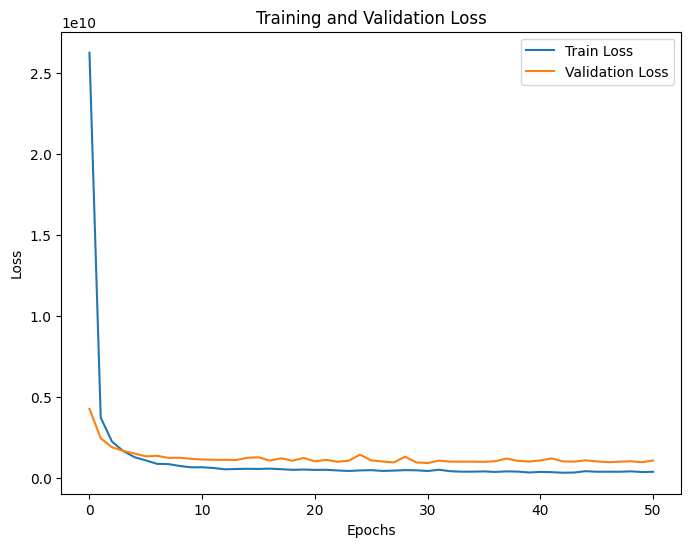

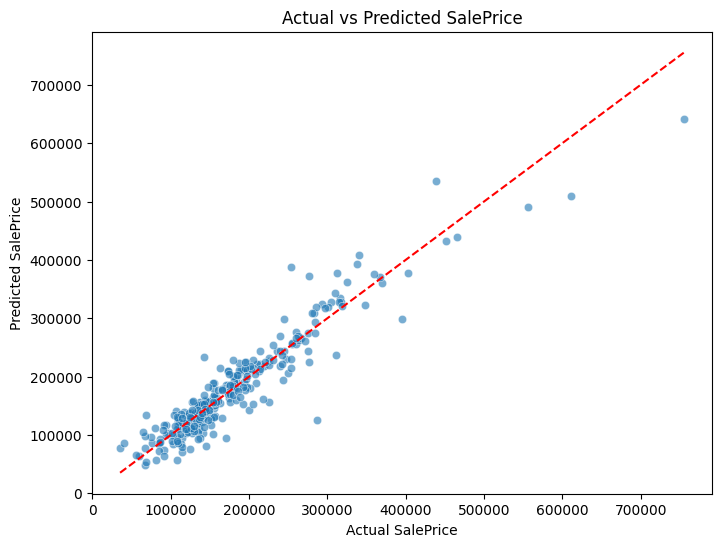

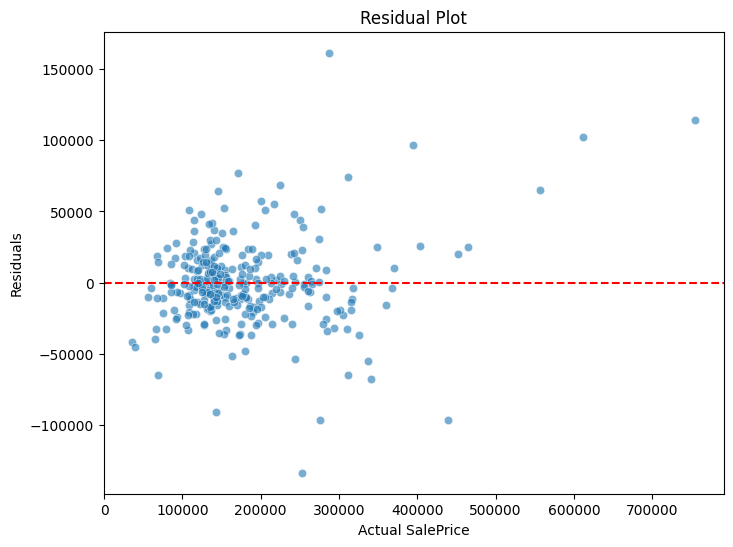

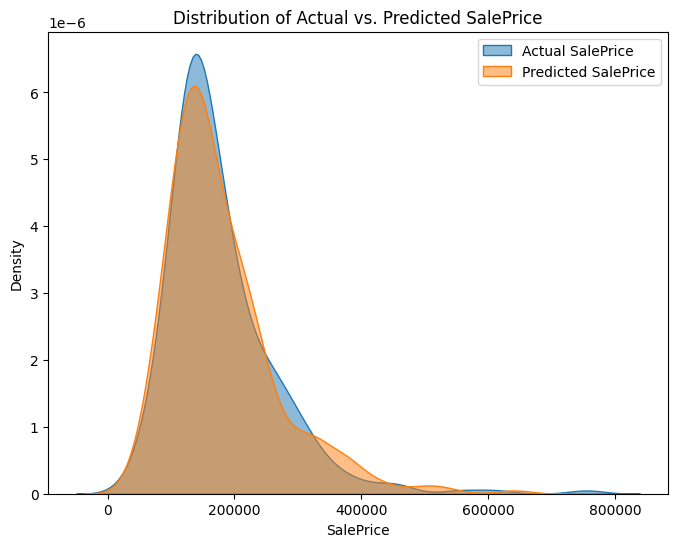

In [6]:
# Load dataset (Assumingdf_final is already loaded)
# Select relevant features
dfdf_final =df_final[['OverallQual', 'InternalSF', 'GrLivArea', 'GarageCars', 'GarageArea', 'FullBath', 'YearBuilt', 'TotalBsmtSF',
         'YearRemodAdd', '1stFlrSF', 'BsmtFinSF1', 'LotArea', 'LotFrontage', 'Fireplaces', 'OverallCond', 'ExterQual_TA', 
         'Neighborhood_Price_Bucket_Level_1', 'Neighborhood_Price_Bucket_Level_4', 'KitchenQual_Gd', 'Neighborhood_Price_Bucket_Level_3', 
         'SalePrice']]

# Define features and target variable
X =df_final.drop(columns=['SalePrice'])
y =df_final['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Explicit input layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer
])



# Define Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.9
)

# Compile with optimized parameters
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='mse',
    metrics=['mae']
)

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with more epochs
history = model.fit(
    X_train_scaled, y_train, epochs=200, batch_size=32,
    validation_data=(X_test_scaled, y_test), verbose=1,
    callbacks=[early_stopping]
)

model.save("models/neural_network_model1.keras")

# Make predictions
y_pred = model.predict(X_test_scaled).flatten()

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"R² Score: {r2:.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dashed')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='dashed')
plt.xlabel("Actual SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Distribution of Predictions
plt.figure(figsize=(8, 6))
sns.kdeplot(y_test, label="Actual SalePrice", fill=True, alpha=0.5)
sns.kdeplot(y_pred, label="Predicted SalePrice", fill=True, alpha=0.5)
plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.title("Distribution of Actual vs. Predicted SalePrice")
plt.legend()
plt.show()

### Full Dataset Feature Engineering Model

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 37025955840.0000 - mae: 173835.9531 - val_loss: 9260409856.0000 - val_mae: 74249.2734
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5816683520.0000 - mae: 57494.5742 - val_loss: 2636938240.0000 - val_mae: 35803.8672
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2257225472.0000 - mae: 32163.3242 - val_loss: 1895216768.0000 - val_mae: 30073.1172
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1339989248.0000 - mae: 25739.8125 - val_loss: 1651013632.0000 - val_mae: 26984.2676
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1011219264.0000 - mae: 22289.1816 - val_loss: 1568460544.0000 - val_mae: 25581.7715
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 855016320.0000 - mae: 20260.3496 - val_loss: 1312768000.0000 - val_mae: 24841.8633
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 767769152.0000 - mae: 19759.5176 - val_loss: 1257319296.0000 - val_mae: 23394.7422

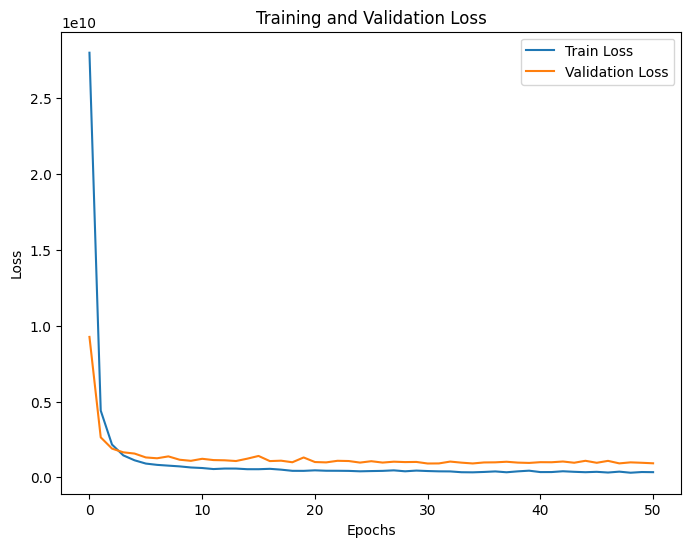

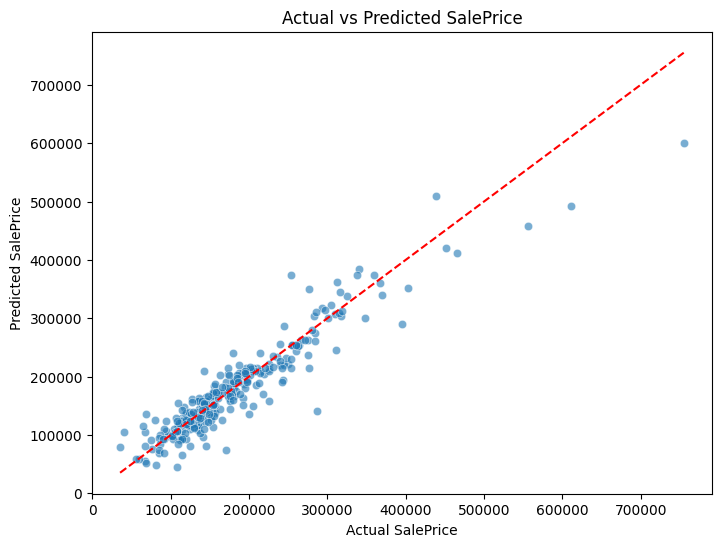

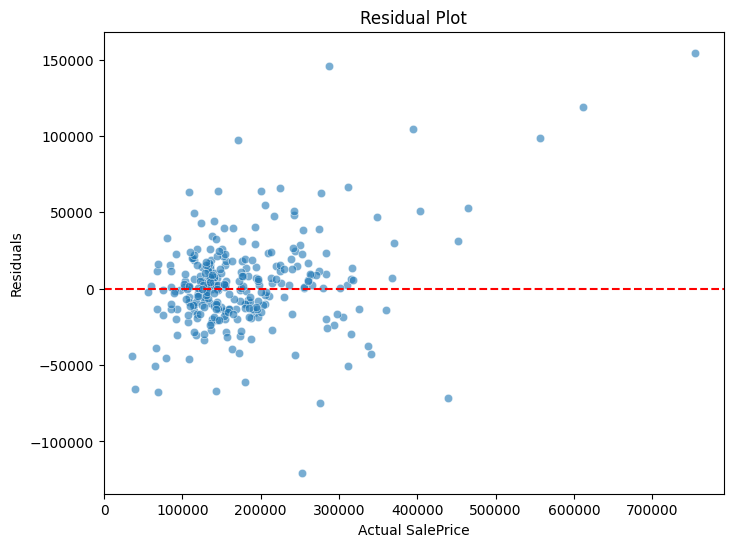

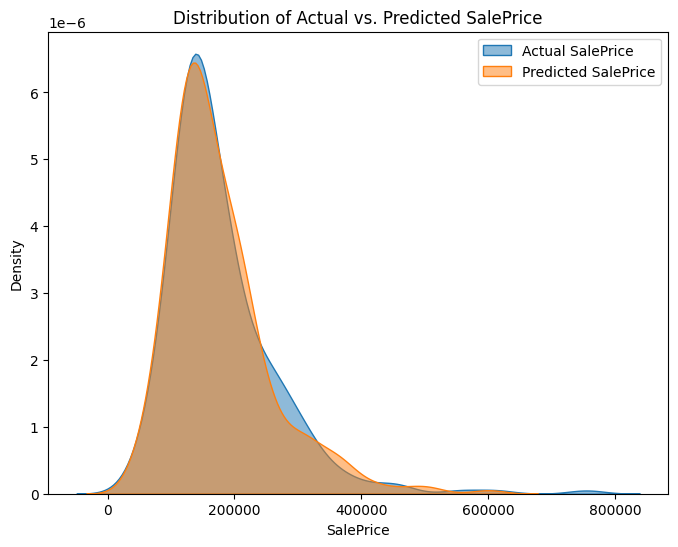

In [7]:
# Load dataset (Assumingdf_final is already loaded)
# Select relevant features
dfdf_final =df_final[['OverallQual', 'InternalSF', 'ExterQual_TA', 'KitchenQual_TA', 'Neighborhood_Price_Bucket_Level_1', 'GarageCars', 'Neighborhood_Price_Bucket_Level_4', 
               'GarageType_Detchd', 'KitchenAbvGr', 'FireplaceQu_Not Applicable', 'TotalBsmtSF', 'GrLivArea', 'YearBuilt', 'Neighborhood_Price_Bucket_Level_3', 
               'GarageFinish_Unf', 'LandContour_Bnk', 'LotShape_Reg', 'MSZoning_RM', 'YearRemodAdd', 'KitchenQual_Gd', 'SalePrice']]

# Define features and target variable
X =df_final.drop(columns=['SalePrice'])
y =df_final['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Explicit input layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer
])



# Define Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.9
)

# Compile with optimized parameters
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='mse',
    metrics=['mae']
)

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with more epochs
history = model.fit(
    X_train_scaled, y_train, epochs=200, batch_size=32,
    validation_data=(X_test_scaled, y_test), verbose=1,
    callbacks=[early_stopping]
)

model.save("models/neural_network_model1.keras")

# Make predictions
y_pred = model.predict(X_test_scaled).flatten()

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"R² Score: {r2:.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dashed')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='dashed')
plt.xlabel("Actual SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Distribution of Predictions
plt.figure(figsize=(8, 6))
sns.kdeplot(y_test, label="Actual SalePrice", fill=True, alpha=0.5)
sns.kdeplot(y_pred, label="Predicted SalePrice", fill=True, alpha=0.5)
plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.title("Distribution of Actual vs. Predicted SalePrice")
plt.legend()
plt.show()

### All features from Continuous and Categorical Data

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 35150737408.0000 - mae: 172380.3438 - val_loss: 10220233728.0000 - val_mae: 77215.9766
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6355218944.0000 - mae: 57162.1914 - val_loss: 2563520256.0000 - val_mae: 35131.4922
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2210922752.0000 - mae: 32741.1914 - val_loss: 1965163648.0000 - val_mae: 29390.3633
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1335670912.0000 - mae: 25614.4629 - val_loss: 1862883072.0000 - val_mae: 28460.3027
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1312590592.0000 - mae: 23609.4863 - val_loss: 1573813504.0000 - val_mae: 25530.7461
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1129068544.0000 - mae: 22144.7207 - val_loss: 1462613376.0000 - val_mae: 24769.3750
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 979411712.0000 - mae: 21132.5039 - val_loss: 1329460096.0000 - val_mae: 24105.24

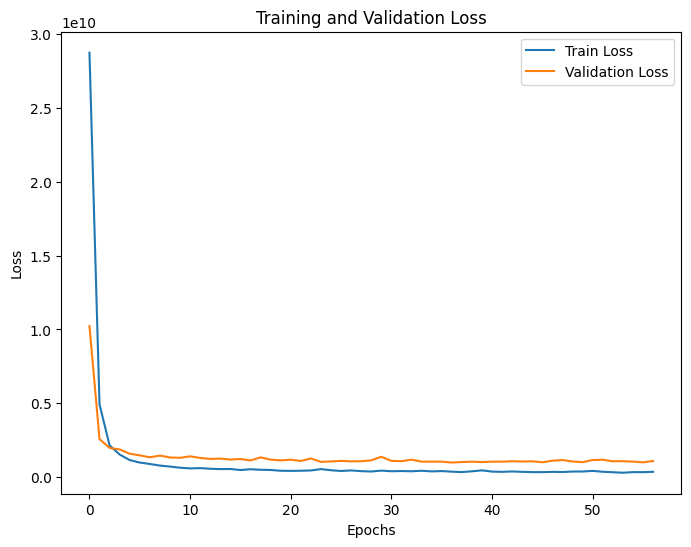

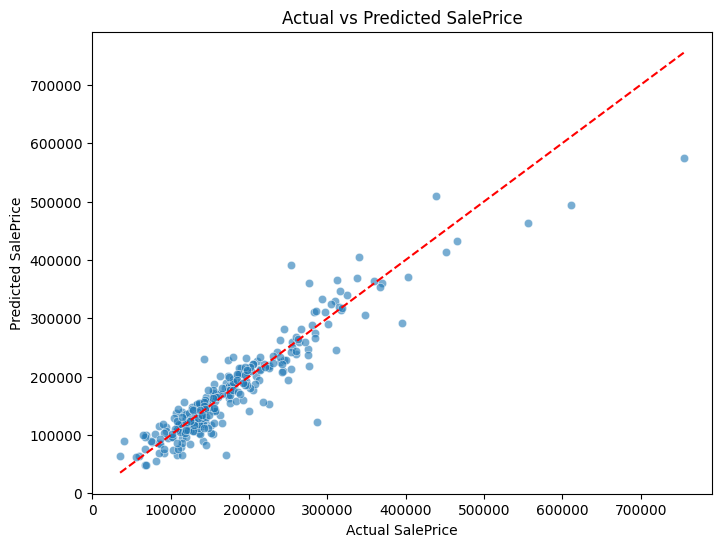

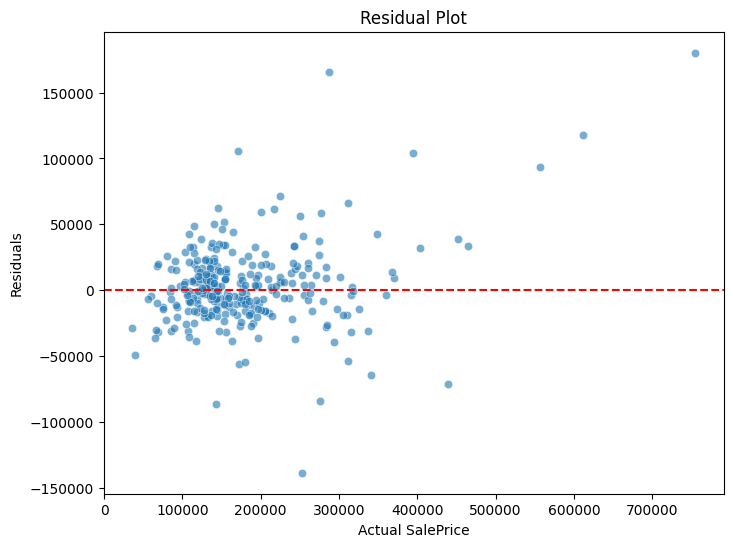

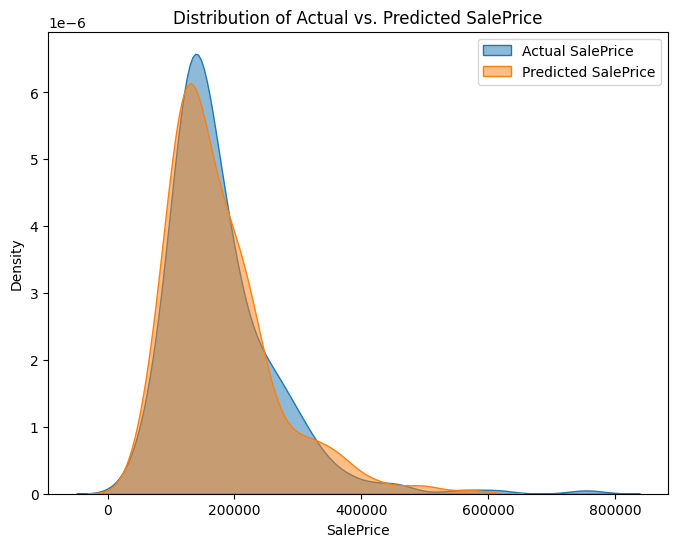

In [8]:
# Select relevant features
df = df_final[['ExterQual_TA', 'Neighborhood_Price_Bucket_Level_4', 'BsmtQual_Ex', 'Neighborhood_Price_Bucket_Level_3', 'KitchenQual_Ex', 'LandSlope_Sev', 
 'FireplaceQu_Not Applicable', 'Neighborhood_Price_Bucket_Level_1', 'RoofStyle_Hip', 'KitchenQual_TA', 'Exterior2nd_Stucco', 'GarageType_Detchd', 
 'KitchenQual_Gd', 'PoolQC_Ex', 'LandSlope_Gtl', 'ExterQual_Gd', 'GarageFinish_Not Applicable', 'ExterQual_Ex', 'LandContour_Bnk', 
 'Neighborhood_Price_Bucket_Level_2' , 'OverallQual', 'GarageCars', 'InternalSF', 'GrLivArea', 'KitchenAbvGr', 'YearBuilt', 'YearRemodAdd', 
 '2ndFlrSF', 'PoolArea', 'Fireplaces', 'LowQualFinSF', 'OverallCond', 'LotFrontage', 'TotalBsmtSF', 'BsmtFullBath', 'ScreenPorch', 'FullBath', 
 'BsmtFinSF1', 'GarageYrBlt', 'MSSubClass', 'SalePrice']]


# Define features and target variable
X =df_final.drop(columns=['SalePrice'])
y =df_final['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Explicit input layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer
])



# Define Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.9
)

# Compile with optimized parameters
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='mse',
    metrics=['mae']
)

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with more epochs
history = model.fit(
    X_train_scaled, y_train, epochs=200, batch_size=32,
    validation_data=(X_test_scaled, y_test), verbose=1,
    callbacks=[early_stopping]
)

model.save("models/neural_network_model1.keras")

# Make predictions
y_pred = model.predict(X_test_scaled).flatten()

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"R² Score: {r2:.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dashed')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='dashed')
plt.xlabel("Actual SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Distribution of Predictions
plt.figure(figsize=(8, 6))
sns.kdeplot(y_test, label="Actual SalePrice", fill=True, alpha=0.5)
sns.kdeplot(y_pred, label="Predicted SalePrice", fill=True, alpha=0.5)
plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.title("Distribution of Actual vs. Predicted SalePrice")
plt.legend()
plt.show()